In [1]:
import torch
import numpy as np

def torch_batch_pix_accuracy(predict, target):
  """PixAcc"""
  # inputs are numpy array, output 4D, target 3D
  assert predict.shape == target.shape
  predict = predict.type(torch.int) + 1
  target = target.type(torch.int) + 1

  pixel_labeled = torch.sum(target > 0)
  pixel_correct = torch.sum((predict == target) * (target > 0))
  assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
  return pixel_correct, pixel_labeled


def torch_batch_intersection_union(predict, target, nclass):
  """mIoU"""
  # inputs are numpy array, output 4D, target 3D
  assert predict.shape == target.shape
  mini = 1
  maxi = nclass
  nbins = nclass
  predict = predict.type(torch.int) + 1
  target = target.type(torch.int) + 1

  predict = predict * (target > 0).type(predict.dtype)
  intersection = predict * (predict == target)
  # areas of intersection and union
  # element 0 in intersection occur the main difference from np.bincount. set boundary to -1 is necessary.
  area_inter, _ = np.histogram(intersection.cpu().numpy(), bins=nbins, range=(mini, maxi))
  area_pred, _ = np.histogram(predict.cpu().numpy(), bins=nbins, range=(mini, maxi))
  area_lab, _ = np.histogram(target.cpu().numpy(), bins=nbins, range=(mini, maxi))
  area_union = area_pred + area_lab - area_inter
  assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
  return torch.tensor( area_inter, device=target.device) , torch.tensor( area_union, device=target.device)


def torch_pixelAccuracy(imPred, imLab):
  """
  This function takes the prediction and label of a single image, returns pixel-wise accuracy
  To compute over many images do:
  for i = range(Nimages):
        (pixel_accuracy[i], pixel_correct[i], pixel_labeled[i]) = \
          pixelAccuracy(imPred[i], imLab[i])
  mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
  """
  # Remove classes from unlabeled pixels in gt image.
  # We should not penalize detections in unlabeled portions of the image.
  pixel_labeled = torch.sum(imLab >= 0)
  pixel_correct = torch.sum((imPred == imLab) * (imLab >= 0))
  pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
  return (pixel_accuracy, pixel_correct, pixel_labeled)


def torch_intersectionAndUnion(imPred, imLab, numClass):
  """
  This function takes the prediction and label of a single image,
  returns intersection and union areas for each class
  To compute over many images do:
  for i in range(Nimages):
      (area_intersection[:,i], area_union[:,i]) = intersectionAndUnion(imPred[i], imLab[i])
  IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)
  """
  # Remove classes from unlabeled pixels in gt image.
  # We should not penalize detections in unlabeled portions of the image.
  imPred = imPred * (imLab >= 0)

  # Compute area intersection:
  intersection = imPred * (imPred == imLab)
  (area_intersection, _) = np.histogram(intersection.cpu().numpy(), bins=numClass, range=(1, numClass))

  # Compute area union:
  (area_pred, _) = np.histogram(imPred.cpu().numpy(), bins=numClass, range=(1, numClass))
  (area_lab, _) = np.histogram(imLab.cpu().numpy(), bins=numClass, range=(1, numClass))
  area_union = area_pred + area_lab - area_intersection
  return (torch.tensor(area_intersection, device=imPred.device) , torch.tensor(area_union, device=imPred.device))


def torch_hist_info(pred, label, num_cls):
  assert pred.shape == label.shape
  k = (label >= 0) & (label < num_cls)
  labeled = torch.sum(k)
  correct = torch.sum((pred[k] == label[k]))
  inp = num_cls * label[k].type(torch.int) + pred[k]
  inp = inp.cpu().numpy()
  return np.bincount(inp, minlength=num_cls ** 2).reshape(num_cls,num_cls), labeled, correct


def torch_compute_score(hist, correct, labeled):
  iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
  # print('right')
  # print(iu)
  mean_IU = np.nanmean(iu)
  mean_IU_no_back = np.nanmean(iu[1:])
  freq = hist.sum(1) / hist.sum()
  freq_IU = (iu[freq > 0] * freq[freq > 0]).sum()
  mean_pixel_acc = correct / labeled

  return iu, mean_IU, mean_IU_no_back, mean_pixel_acc

In [2]:
def batch_pix_accuracy(predict, target):
    """PixAcc"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    pixel_labeled = np.sum(target > 0)
    pixel_correct = np.sum((predict == target) * (target > 0))
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct, pixel_labeled


def batch_intersection_union(predict, target, nclass):
    """mIoU"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    mini = 1
    maxi = nclass
    nbins = nclass
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    predict = predict * (target > 0).astype(predict.dtype)
    intersection = predict * (predict == target)
    # areas of intersection and union
    # element 0 in intersection occur the main difference from np.bincount. set boundary to -1 is necessary.
    area_inter, _ = np.histogram(intersection, bins=nbins, range=(mini, maxi))
    area_pred, _ = np.histogram(predict, bins=nbins, range=(mini, maxi))
    area_lab, _ = np.histogram(target, bins=nbins, range=(mini, maxi))
    area_union = area_pred + area_lab - area_inter
    assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
    return area_inter, area_union


def pixelAccuracy(imPred, imLab):
    """
    This function takes the prediction and label of a single image, returns pixel-wise accuracy
    To compute over many images do:
    for i = range(Nimages):
         (pixel_accuracy[i], pixel_correct[i], pixel_labeled[i]) = \
            pixelAccuracy(imPred[i], imLab[i])
    mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    pixel_labeled = np.sum(imLab >= 0)
    pixel_correct = np.sum((imPred == imLab) * (imLab >= 0))
    pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
    return (pixel_accuracy, pixel_correct, pixel_labeled)


def intersectionAndUnion(imPred, imLab, numClass):
    """
    This function takes the prediction and label of a single image,
    returns intersection and union areas for each class
    To compute over many images do:
    for i in range(Nimages):
        (area_intersection[:,i], area_union[:,i]) = intersectionAndUnion(imPred[i], imLab[i])
    IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab >= 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection
    return (area_intersection, area_union)


def hist_info(pred, label, num_cls):
    assert pred.shape == label.shape
    k = (label >= 0) & (label < num_cls)
    labeled = np.sum(k)
    correct = np.sum((pred[k] == label[k]))

    return np.bincount(num_cls * label[k].astype(int) + pred[k], minlength=num_cls ** 2).reshape(num_cls,
                                                                                                 num_cls), labeled, correct


def compute_score(hist, correct, labeled):
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    # print('right')
    # print(iu)
    mean_IU = np.nanmean(iu)
    mean_IU_no_back = np.nanmean(iu[1:])
    freq = hist.sum(1) / hist.sum()
    freq_IU = (iu[freq > 0] * freq[freq > 0]).sum()
    mean_pixel_acc = correct / labeled

    return iu, mean_IU, mean_IU_no_back, mean_pixel_acc

In [7]:
BS,W,H = 2,400,400
pred = torch.randint(low=0,high=19,size=(BS,W,H))
target = torch.randint(low=0,high=19,size=(BS,W,H))
torch_batch_pix_accuracy(pred, target), batch_pix_accuracy(pred.numpy(), target.numpy())

torch_batch_intersection_union(pred, target,19), batch_intersection_union(pred.numpy(), target.numpy(),19)



((tensor([941, 901, 921, 871, 914, 869, 922, 818, 844, 874, 866, 913, 912, 878,
          925, 831, 868, 894, 865]),
  tensor([32893, 32822, 32750, 32846, 32995, 32801, 33098, 32665, 32773, 32844,
          32433, 32660, 32977, 32880, 33011, 32919, 32675, 32568, 32563])),
 (array([941, 901, 921, 871, 914, 869, 922, 818, 844, 874, 866, 913, 912,
         878, 925, 831, 868, 894, 865]),
  array([32893, 32822, 32750, 32846, 32995, 32801, 33098, 32665, 32773,
         32844, 32433, 32660, 32977, 32880, 33011, 32919, 32675, 32568,
         32563])))

In [8]:
# lambda learning rate calculator 

target_lr + (base_lr - target_lr) * pow(1 - T / N, power)



20

In [10]:
"""Popular Learning Rate Schedulers"""
from __future__ import division
import math


class LRScheduler(object):
    r"""Learning Rate Scheduler
    Parameters
    ----------
    mode : str
        Modes for learning rate scheduler.
        Currently it supports 'constant', 'step', 'linear', 'poly' and 'cosine'.
    base_lr : float
        Base learning rate, i.e. the starting learning rate.
    target_lr : float
        Target learning rate, i.e. the ending learning rate.
        With constant mode target_lr is ignored.
    niters : int
        Number of iterations to be scheduled.
    nepochs : int
        Number of epochs to be scheduled.
    iters_per_epoch : int
        Number of iterations in each epoch.
    offset : int
        Number of iterations before this scheduler.
    power : float
        Power parameter of poly scheduler.
    step_iter : list
        A list of iterations to decay the learning rate.
    step_epoch : list
        A list of epochs to decay the learning rate.
    step_factor : float
        Learning rate decay factor.
    """

    def __init__(self, mode, base_lr=0.01, target_lr=0, niters=0, nepochs=0, iters_per_epoch=0,
                 offset=0, power=2, step_iter=None, step_epoch=None, step_factor=0.1):
        super(LRScheduler, self).__init__()
        assert (mode in ['constant', 'step', 'linear', 'poly', 'cosine'])

        self.mode = mode
        if mode == 'step':
            assert (step_iter is not None or step_epoch is not None)
        self.base_lr = base_lr
        self.target_lr = target_lr
        if self.mode == 'constant':
            self.target_lr = self.base_lr

        self.niters = niters
        self.step = step_iter
        epoch_iters = nepochs * iters_per_epoch
        if epoch_iters > 0:
            self.niters = epoch_iters
            if step_epoch is not None:
                self.step = [s * iters_per_epoch for s in step_epoch]

        self.offset = offset
        self.power = power
        self.step_factor = step_factor

    def __call__(self, num_update):
        self.update(num_update)
        return self.learning_rate

    def update(self, num_update):
        N = self.niters - 1
        T = num_update - self.offset
        T = min(max(0, T), N)

        if self.mode == 'constant':
            factor = 0
        elif self.mode == 'linear':
            factor = 1 - T / N
        elif self.mode == 'poly':
            factor = pow(1 - T / N, self.power)
        elif self.mode == 'cosine':
            factor = (1 + math.cos(math.pi * T / N)) / 2
        elif self.mode == 'step':
            if self.step is not None:
                count = sum([1 for s in self.step if s <= T])
                factor = pow(self.step_factor, count)
            else:
                factor = 1
        else:
            raise NotImplementedError

        if self.mode == 'step':
            self.learning_rate = self.base_lr * factor
        else:
            self.learning_rate = self.target_lr + (self.base_lr - self.target_lr) * factor


if __name__ == '__main__':
    lr_scheduler = LRScheduler(mode='poly', base_lr=0.01, nepochs=10,
                               iters_per_epoch=176, power=0.9)
    for i in range(60 * 176):
        lr = lr_scheduler(i)
        
        print(lr)

0.01
0.00999488331104007
0.009989766331020139
0.009984649059757985
0.009979531497071153
0.009974413642776986
0.009969295496692598
0.009964177058634885
0.009959058328420527
0.009953939305865982
0.00994881999078749
0.009943700383001063
0.009938580482322502
0.009933460288567382
0.009928339801551053
0.009923219021088649
0.009918097946995077
0.00991297657908502
0.009907854917172944
0.009902732961073085
0.009897610710599455
0.009892488165565849
0.009887365325785824
0.009882242191072723
0.009877118761239659
0.009871995036099519
0.00986687101546496
0.00986174669914842
0.009856622086962101
0.009851497178717984
0.009846371974227814
0.009841246473303119
0.009836120675755183
0.009830994581395074
0.009825868190033624
0.009820741501481434
0.009815614515548876
0.00981048723204609
0.009805359650782986
0.00980023177156924
0.009795103594214299
0.00978997511852737
0.009784846344317437
0.009779717271393241
0.009774587899563295
0.009769458228635876
0.009764328258419021
0.009759197988720544
0.00975406741934

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


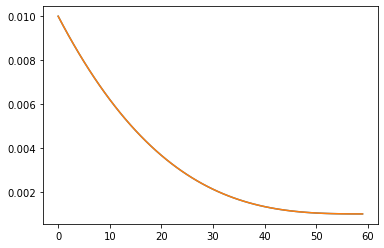

In [46]:

power = 3
max_epoch = 60
lambda_lr= lambda epoch: power ** epoch 
init_lr = 0.01
target_lr = 0.001

lambda_lr= lambda epoch: (((max_epoch -epoch)/max_epoch)**(power) ) + (1-(((max_epoch -epoch)/max_epoch)**(power)))*target_lr/init_lr
# for scale init_lr to 0 the factor
l1 = []
l2 = []

if __name__ == '__main__':
    lr_scheduler = LRScheduler(mode='poly', base_lr=0.01, nepochs=60,target_lr= target_lr,
                               iters_per_epoch=176, power=power)
    for i in range(60 * 176):
        lr = lr_scheduler(i)
        #print(lr)
        
        if i % 176 == 0:
            lr = lr_scheduler(i)
            l2.append( lr )
            l1.append( lambda_lr(i/176)*0.01 )
            

x = list( range( 0, len(l1)) )

import matplotlib.pyplot as plt
plt.plot(x, l2)
plt.plot(x, l1)
#plt.axis([0, 6, 0, 20])
plt.show()


In [97]:
import os 
os.chdir('/home/jonfrey/ASL')
import sys
sys.path.append( os.path.join( os.getcwd(), 'src'))

import torch
import numpy as np
BS,W,H = 2,400,400
num_classes = 19
predicted = torch.randint(low=0,high=num_classes,size=(BS,W,H))
target = torch.randint(low=0,high=num_classes,size=(BS,W,H))

predicted_st = predicted.clone()
target_st = target.clone()

from pytorch_lightning import metrics as pl_metrics
iou = pl_metrics.functional.classification.iou(predicted , target, num_classes= num_classes)
print("Orginal pl lightning", iou)
print(torch.max(predicted))


from lightning import IoU

metric_val_IoU = IoU(num_classes=num_classes)
val = metric_val_IoU (predicted,target)
print('SCCN IMP IoU',val)





Orginal pl lightning tensor(0.0267)
tensor(18)
SCCN IMP IoU tensor(0.0267)


In [100]:

class Metric(object):
    """Base class for all metrics.
    From: https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py
    """
    def reset(self):
        pass

    def add(self):
        pass

    def value(self):
        pass
    
import numpy as np
import torch

class ConfusionMatrix(Metric):
    """Constructs a confusion matrix for a multi-class classification problems.
    Does not support multi-label, multi-class problems.
    Keyword arguments:
    - num_classes (int): number of classes in the classification problem.
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    Modified from: https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
    """

    def __init__(self, num_classes, normalized=False):
        super().__init__()

        self.conf = np.ndarray((num_classes, num_classes), dtype=np.int64)
        self.normalized = normalized
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.conf.fill(0)

    def add(self, predicted, target):
        """Computes the confusion matrix
        The shape of the confusion matrix is K x K, where K is the number
        of classes.
        Keyword arguments:
        - predicted (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        predicted scores obtained from the model for N examples and K classes,
        or an N-tensor/array of integer values between 0 and K-1.
        - target (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        ground-truth classes for N examples and K classes, or an N-tensor/array
        of integer values between 0 and K-1.
        """
        # If target and/or predicted are tensors, convert them to numpy arrays
        if torch.is_tensor(predicted):
            predicted = predicted.cpu().numpy()
        if torch.is_tensor(target):
            target = target.cpu().numpy()

        assert predicted.shape[0] == target.shape[0], \
            'number of targets and predicted outputs do not match'

        if np.ndim(predicted) != 1:
            assert predicted.shape[1] == self.num_classes, \
                'number of predictions does not match size of confusion matrix'
            predicted = np.argmax(predicted, 1)
        else:
            assert (predicted.max() < self.num_classes) and (predicted.min() >= 0), \
                'predicted values are not between 0 and k-1'

        if np.ndim(target) != 1:
            assert target.shape[1] == self.num_classes, \
                'Onehot target does not match size of confusion matrix'
            assert (target >= 0).all() and (target <= 1).all(), \
                'in one-hot encoding, target values should be 0 or 1'
            assert (target.sum(1) == 1).all(), \
                'multi-label setting is not supported'
            target = np.argmax(target, 1)
        else:
            assert (target.max() < self.num_classes) and (target.min() >= 0), \
                'target values are not between 0 and k-1'

        # hack for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int64), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        self.conf += conf

    def value(self):
        """
        Returns:
            Confustion matrix of K rows and K columns, where rows corresponds
            to ground-truth targets and columns corresponds to predicted
            targets.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self.conf
import torch
import numpy as np

class IoU(Metric):
    """Computes the intersection over union (IoU) per class and corresponding
    mean (mIoU).
    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:
        IoU = true_positive / (true_positive + false_positive + false_negative).
    Keyword arguments:
    - num_classes (int): number of classes in the classification problem
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    - ignore_index (int or iterable, optional): Index of the classes to ignore
    when computing the IoU. Can be an int, or any iterable of ints.
    """

    def __init__(self, num_classes, normalized=False, ignore_index=None):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized)

        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)
        else:
            try:
                self.ignore_index = tuple(ignore_index)
            except TypeError:
                raise ValueError("'ignore_index' must be an int or iterable")

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):
        """Adds the predicted and target pair to the IoU metric.
        Keyword arguments:
        - predicted (Tensor): Can be a (N, K, H, W) tensor of
        predicted scores obtained from the model for N examples and K classes,
        or (N, H, W) tensor of integer values between 0 and K-1.
        - target (Tensor): Can be a (N, K, H, W) tensor of
        target scores for N examples and K classes, or (N, H, W) tensor of
        integer values between 0 and K-1.
        """
        # Dimensions check
        assert predicted.size(0) == target.size(0), \
            'number of targets and predicted outputs do not match'
        assert predicted.dim() == 3 or predicted.dim() == 4, \
            "predictions must be of dimension (N, H, W) or (N, K, H, W)"
        assert target.dim() == 3 or target.dim() == 4, \
            "targets must be of dimension (N, H, W) or (N, K, H, W)"

        # If the tensor is in categorical format convert it to integer format
        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):
        """Computes the IoU and mean IoU.
        The mean computation ignores NaN elements of the IoU array.
        Returns:
            Tuple: (IoU, mIoU). The first output is the per class IoU,
            for K classes it's numpy.ndarray with K elements. The second output,
            is the mean IoU.
        """
        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)

iou_unet = IoU(num_classes=num_classes)
iou_unet.add(predicted.clone(), target.clone())
print('VALUE UNET', iou_unet.value())

VALUE UNET (array([0.0264705 , 0.02665444, 0.02668612, 0.02611504, 0.02772575,
       0.02828769, 0.0279821 , 0.02699587, 0.02666707, 0.02528098,
       0.02673225, 0.02642959, 0.02508972, 0.02660207, 0.02691921,
       0.02648683, 0.02570749, 0.0264621 , 0.02721336]), 0.026658325910806753)
